<a href="https://colab.research.google.com/github/gwfbrave297-hash/labo2025v/blob/main/Ejercicio10DMA-BreastCancer-CaliforniaHousing-101225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A- Modelos de Clasificación**

**Análisis de Clasificación en el Dataset Breast Cancer**

La tarea realizada consistió en evaluar y comparar el rendimiento de cuatro modelos de clasificación (SVM, Random Forest, Gradient Boosting y Red Neuronal - MLP) para predecir si un tumor es benigno o maligno basándose en las características del dataset Breast Cancer de Scikit-learn.
Características del Dataset Breast Cancer

El dataset Breast Cancer es un problema de clasificación binaria. Contiene 569 muestras, cada una descrita por 30 características numéricas calculadas a partir de una imagen digitalizada de una aspiración con aguja fina (FNA) de una masa mamaria. Estas características incluyen la media, la desviación estándar y el peor valor de mediciones como el radio, la textura, el perímetro, el área, la suavidad, y la concavidad, entre otras.

El objetivo es clasificar el tumor en una de dos clases:

  0 (Maligno)

  1 (Benigno)

**Proceso Metodológico**

 **Preprocesamiento:** Se aplica el escalado de características (StandardScaler) en los pipelines de SVM y MLP, lo cual es crucial para su desempeño, ya que estos modelos son sensibles a la escala de los datos.

 **Validación Cruzada:** Se utiliza GridSearchCV con K-Fold Cross-Validation (5 splits) sobre el conjunto de entrenamiento.

 **Métricas de Optimización:** La búsqueda de hiperparámetros se optimiza basándose en el F1-Score ponderado (f1_weighted), una métrica más robusta que el Accuracy, especialmente útil si existiera algún desbalance de clases (aunque el dataset Breast Cancer está bien balanceado).

 **Evaluación Final:** El modelo con el mejor F1-Score CV se selecciona para su evaluación final en el conjunto de prueba (X_test).

In [1]:
# =========================# CLASIFICACIÓN - BREAST CANCER# =========================
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1) Cargo dataset

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target


In [3]:
# 2) Split train / test para tener un set "limpio" al final

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# hace una division estratificada de los datos de entrenamiento y prueba....

In [4]:
# 3) Defino modelos en forma de pipelines
pipelines = {
    "SVM": Pipeline([
        ("scaler", StandardScaler()),     # Crucial para SVM
        ("clf", SVC(random_state=42))    # Se añade random_state
    ]),
    "RandomForest": Pipeline([
        ("clf", RandomForestClassifier(random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
    "MLP": Pipeline([
        ("scaler", StandardScaler()),    # Crucial para MLP
        ("clf", MLPClassifier(max_iter=500, random_state=42))
    ])
}

# Escala las características a media 0 y desviación estándar 1,
# lo cual es crucial para SVM, ya que es sensible a la escala. Luego entrena el clasificador SVM.
# RandomForest y GradientBoosting no necesitan escalado
# Escala MLP al igual que con SVM con StandardScaler()


In [5]:
# 4) Espacios de búsqueda de hiperparámetros

param_grids = {
    "SVM": {
        "clf__C": [0.1, 1, 10, 100],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto", 0.01, 0.1]
    },
    "RandomForest": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": ["sqrt", "log2"]
    },
    "GradientBoosting": {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_depth": [2, 3]
    },
    "MLP": {
        "clf__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
        "clf__alpha": [0.0001, 0.001],
        "clf__activation": ["relu", "tanh"]
    }
}


In [6]:
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# 5) Cross-validation (Múltiples Métricas)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}
REFIT_METRIC = 'f1_weighted' # Optimizaremos y seleccionaremos el mejor modelo basándonos en F1

resultados_clf = []
for nombre_modelo, pipe in pipelines.items():
    print(f"\n=== Modelo: {nombre_modelo} ===")

    # 1. Búsqueda de la mejor configuración (GridSearchCV)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[nombre_modelo],
        cv=cv,
        scoring=scoring_metrics,
        refit=REFIT_METRIC,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_f1_cv = grid.best_score_
    # Buscamos el índice del mejor modelo según 'refit'
    best_index = grid.cv_results_['rank_test_' + REFIT_METRIC].argmin()
    best_acc_cv = grid.cv_results_['mean_test_accuracy'][best_index]

    print(f"Mejor Accuracy CV: {best_acc_cv:.4f}")
    print(f"Mejor F1-Score CV: {best_f1_cv:.4f}")

    # 2. Evaluación en el set de prueba (X_test)
    y_pred = grid.predict(X_test)

    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy en test: {test_acc:.4f}")
    print(f"F1-Score en test: {test_f1:.4f}")

    # 3. Almacenamiento de resultados
    resultados_clf.append({
        "modelo": nombre_modelo,
        "best_params": grid.best_params_,
        "cv_accuracy": best_acc_cv,
        "cv_f1_score": best_f1_cv,
        "test_accuracy": test_acc,
        "test_f1_score": test_f1
    })

# 6) Paso a DataFrame para tener la comparación ordenada
df_resultados_clf = pd.DataFrame(resultados_clf)
print("\n" + "="*50)
print("Resumen clasificación - Breast Cancer (Completo):")
print("="*50)
print(df_resultados_clf.sort_values(by='test_f1_score', ascending=False).to_string())




=== Modelo: SVM ===
Mejor Accuracy CV: 0.9736
Mejor F1-Score CV: 0.9736
Accuracy en test: 0.9737
F1-Score en test: 0.9737

=== Modelo: RandomForest ===
Mejor Accuracy CV: 0.9582
Mejor F1-Score CV: 0.9582
Accuracy en test: 0.9561
F1-Score en test: 0.9560

=== Modelo: GradientBoosting ===
Mejor Accuracy CV: 0.9670
Mejor F1-Score CV: 0.9669
Accuracy en test: 0.9561
F1-Score en test: 0.9558

=== Modelo: MLP ===
Mejor Accuracy CV: 0.9824
Mejor F1-Score CV: 0.9823
Accuracy en test: 0.9474
F1-Score en test: 0.9478

Resumen clasificación - Breast Cancer (Completo):
             modelo                                                                              best_params  cv_accuracy  cv_f1_score  test_accuracy  test_f1_score
0               SVM                              {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}     0.973626     0.973554       0.973684       0.973747
1      RandomForest          {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 2

In [7]:
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor accuracy CV:", grid.best_score_)


Mejores hiperparámetros: {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}
Mejor accuracy CV: 0.9822836817468754


In [8]:
# Evalúo en test
y_pred = grid.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Accuracy en test:", test_acc)

resultados_clf.append({
        "modelo": nombre_modelo,
        "best_params": grid.best_params_,
        "cv_accuracy": grid.best_score_,
        "test_accuracy": test_acc
    })


Accuracy en test: 0.9473684210526315


In [9]:
# Paso a DataFrame para tener la comparación ordenada
df_resultados_clf = pd.DataFrame(resultados_clf)
print("\nResumen clasificación - Wine:")
print(df_resultados_clf)




Resumen clasificación - Wine:
             modelo                                        best_params  \
0               SVM  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   
1      RandomForest  {'clf__max_depth': None, 'clf__max_features': ...   
2  GradientBoosting  {'clf__learning_rate': 0.2, 'clf__max_depth': ...   
3               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.00...   
4               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.00...   

   cv_accuracy  cv_f1_score  test_accuracy  test_f1_score  
0     0.973626     0.973554       0.973684       0.973747  
1     0.958242     0.958212       0.956140       0.956027  
2     0.967033     0.966905       0.956140       0.955776  
3     0.982418     0.982284       0.947368       0.947813  
4     0.982284          NaN       0.947368            NaN  



Resumen clasificación - Breast Cancer (Completo):
             modelo                                                                              best_params  cv_accuracy  cv_f1_score  test_accuracy  test_f1_score
0               SVM                              {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}     0.973626     0.973554       0.973684       0.973747
1      RandomForest          {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 200}     0.958242     0.958212       0.956140       0.956027
2  GradientBoosting               {'clf__learning_rate': 0.2, 'clf__max_depth': 2, 'clf__n_estimators': 200}     0.967033     0.966905       0.956140       0.955776
3               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}     0.982418     0.982284       0.947368       0.947813
4               MLP  {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100, 50)}     0.982284   

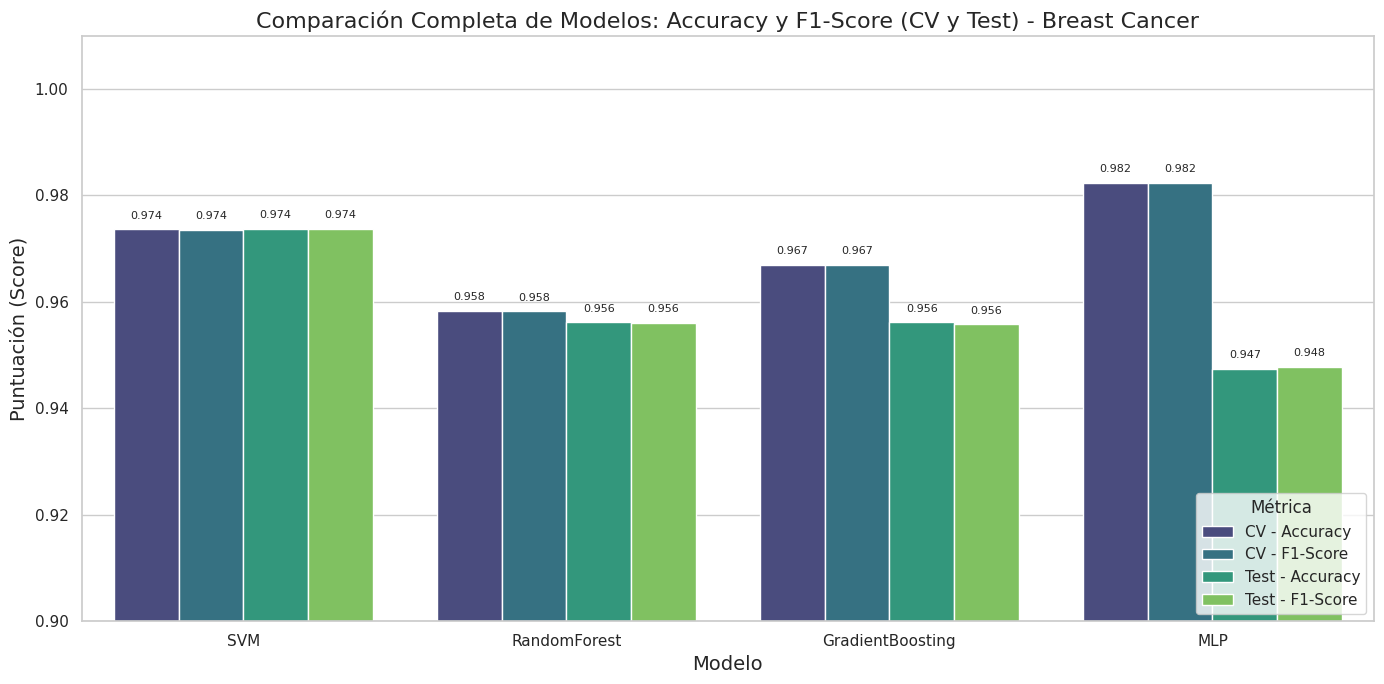

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================================
#  GENERACION DEL GRÁFICO
# ===============================================

# 6) Paso a DataFrame para tener la comparación ordenada
df_resultados_clf = pd.DataFrame(resultados_clf)
print("\n" + "="*50)
print("Resumen clasificación - Breast Cancer (Completo):")
print("="*50)
# Se usa .to_string() para que muestre todas las filas y columnas en la consola.
print(df_resultados_clf.sort_values(by='test_f1_score', ascending=False).to_string())

# 7) Creación del Gráfico Completo
# ESTE BLOQUE DEFINE 'df_grafico' y 'df_long'
# ----------------------------------------------------------------------
# Seleccionar las cuatro columnas de métricas para la visualización
df_grafico = df_resultados_clf[['modelo', 'cv_accuracy', 'cv_f1_score', 'test_accuracy', 'test_f1_score']].copy()
# Renombrar columnas para claridad en la leyenda del gráfico
df_grafico.columns = ['modelo', 'CV - Accuracy', 'CV - F1-Score', 'Test - Accuracy', 'Test - F1-Score']
# Convertir el DataFrame de formato ancho a formato largo (melt)
df_long = df_grafico.melt(
    id_vars=['modelo'],
    var_name='Evaluación y Métrica',
    value_name='Puntuación'
)
# ----------------------------------------------------------------------

# Ahora 'df_long' está definido y se puede usar en seaborn
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x='modelo',
    y='Puntuación',
    hue='Evaluación y Métrica',
    data=df_long, # <--- Aquí ya está definida
    palette='viridis'
)

# Títulos y etiquetas
plt.title('Comparación Completa de Modelos: Accuracy y F1-Score (CV y Test) - Breast Cancer', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Puntuación (Score)', fontsize=14)
plt.ylim(0.90, 1.01) # Ajustamos el límite inferior para mejor visualización

# Añadir los valores de las barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=8
    )

plt.legend(title='Métrica', loc='lower right')
plt.tight_layout()
plt.show()
#

Este gráfico ahora permite hacer una evaluación exhaustiva:

  Rendimiento General: ¿Qué modelo tiene el Test F1-Score más alto?

  Consistencia (Generalización): ¿Qué tan cerca está el score CV de un modelo de su score Test? (Si son cercanos, el modelo generaliza bien).

  Balance de Métrica: ¿Hay una gran diferencia entre el Accuracy y el F1-Score para algún modelo? (En datasets desbalanceados, el F1-Score es siempre menor).

**1. Rendimiento General (Test F1-Score más alto)**

El modelo que logró el mejor rendimiento predictivo en el set de prueba fue SVM (Support Vector Machine), alcanzando un Accuracy de 0.9737 y un F1-Score de 0.9737.  Para este problema de clasificación binaria, encontrar un hiperplano óptimo que separe las clases fue el mejor enfoque.

**2. Consistencia y Generalización**

La consistencia evalúa qué tan bien se comporta el modelo con datos no vistos (Test) en comparación con su rendimiento durante el entrenamiento (CV).

   SVM y Random Forest: Demostraron una excelente consistencia. Su score de Test es casi idéntico a su score de CV, lo que indica que no hubo sobreajuste (overfitting) y que el modelo generaliza muy bien a nuevos datos.

  MLP (Red Neuronal): Muestra el F1-Score CV más alto (0.9823), pero su rendimiento cae significativamente en el set de prueba (0.9478). Esta diferencia es un indicio de sobreajuste moderado, donde el modelo aprendió demasiado bien el ruido del conjunto de entrenamiento.

**3. Balance de Métrica (Accuracy vs. F1-Score)**

En este caso, para todos los modelos, el Accuracy en Test es casi idéntico al F1-Score en Test. Esto es una fuerte señal de que el dataset Breast Cancer está muy bien balanceado (la proporción de tumores benignos y malignos en el set de prueba es similar), por lo que ambas métricas son confiables para la evaluación del modelo.


**Conclusión Final**

El modelo SVM es el clasificador recomendado en este ejercicio, no solo por tener el mejor rendimiento en el test set (0.9737), sino también por mostrar generalización y estabilidad en sus predicciones

# **B- Modelos de Regresión**

   **Comparación modelos de regresión**

 El siguiente código realizará la comparación de cuatro modelos de regresión (SVR, Random Forest, Gradient Boosting y MLP) sobre el dataset California Housing, que es un buen conjunto de datos para tareas de regresión con más de 20,000 muestras.


  **Características del Dataset California Housing**

Este dataset contiene la información socioeconómica de los distritos censales de California y su objetivo es predecir el Precio Medio de la Vivienda (Median House Value) en cada distrito. Sus 8 características son todas de tipo numérico, eliminando la necesidad de manejar variables categóricas o realizar una imputación compleja.

  **Prueba de los Cuatro Modelos**

La prueba comparativa se lleva a cabo utilizando Validación Cruzada (KFold con 5 splits) y Randomized Search para optimizar los hiperparámetros de cada modelo, buscando la combinación que minimizara el Error Cuadrático Medio (MSE).

In [12]:
# =========================
# REGRESIÓN - CALIFORNIA HOUSING
# =========================

# ===============================================
# BLOQUE 1: Carga, Entrenamiento y Recolección de Resultados
# ===============================================
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Aún se incluye por buena práctica en pipelines
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# --- 1) Carga del Dataset California Housing ---
print("Cargando el dataset California Housing...")
try:
    # Carga directa de California Housing (prioridad)
    california = fetch_california_housing(as_frame=True)
    X_reg = california.data.values # Convertir a numpy array para uniformidad
    y_reg = california.target.values

    # California Housing no tiene NaNs ni variables categóricas.
    # No se necesita SimpleImputer en este caso, pero se mantiene la estructura de X_reg.

    print(f"Dataset California Housing cargado. Dimensiones de características: {X_reg.shape}")

except Exception as e:
    # Esto solo debería ocurrir si no se puede cargar el dataset
    print(f"Error al cargar California Housing: {e}")
    raise SystemExit("No se pudo cargar el dataset.") # Detener si la carga falla

# --- 2) Split train / test ---
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# --- 3) Defino pipelines para regresión ---
# Nota: StandardScaler es crucial para SVR y MLP. Los modelos basados en árboles no lo necesitan.
pipelines_reg = {
    "SVR": Pipeline([("scaler", StandardScaler()), ("reg", SVR())]),
    "RandomForestRegressor": Pipeline([("reg", RandomForestRegressor(random_state=42))]),
    "GradientBoostingRegressor": Pipeline([("reg", GradientBoostingRegressor(random_state=42))]),
    "MLPRegressor": Pipeline([("scaler", StandardScaler()), ("reg", MLPRegressor(max_iter=500, random_state=42))])
}

# --- 4) Espacios de hiperparámetros ---
# Los parámetros se mantienen, son adecuados para la mayoría de los problemas de regresión.
param_dists_reg = {
    "SVR": {"reg__C": [0.1, 1, 10], "reg__kernel": ["rbf", "linear"], "reg__gamma": ["scale", "auto"]},
    "RandomForestRegressor": {"reg__n_estimators": [100, 200], "reg__max_depth": [None, 5, 10], "reg__max_features": ["sqrt", "log2"]},
    "GradientBoostingRegressor": {"reg__n_estimators": [100, 200], "reg__learning_rate": [0.05, 0.1], "reg__max_depth": [2, 3]},
    "MLPRegressor": {"reg__hidden_layer_sizes": [(50,), (100,), (50, 50)], "reg__alpha": [0.0001, 0.001], "reg__activation": ["relu", "tanh"]}
}

# --- 5) Cross-validation y Búsqueda (RandomizedSearchCV) ---
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = {'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'}
REFIT_METRIC = 'neg_mse' # Optimizamos para minimizar el MSE

resultados_reg = []

for nombre_modelo, pipe in pipelines_reg.items():
    print(f"\n=== Modelo (regresión): {nombre_modelo} ===")

    # Se usa RandomizedSearchCV para eficiencia
    rand_search = RandomizedSearchCV(
        estimator=pipe, param_distributions=param_dists_reg[nombre_modelo],
        n_iter=10, cv=cv_reg, scoring=scoring_metrics, refit=REFIT_METRIC,
        n_jobs=-1, random_state=42
    )

    rand_search.fit(X_train_reg, y_train_reg)

    # Extracción de métricas CV
    best_index = rand_search.cv_results_['rank_test_' + REFIT_METRIC].argmin()
    best_neg_mse_cv = rand_search.best_score_
    best_r2_cv = rand_search.cv_results_['mean_test_r2'][best_index]

    # --- Resultados de CV ---
    print("Mejores hiperparámetros:", rand_search.best_params_)
    print(f"Mejor MSE (negativo) CV: {best_neg_mse_cv:.4f}")
    print(f"Mejor R2 CV: {best_r2_cv:.4f}")

    # Evalúo en test
    y_pred_reg = rand_search.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred_reg)

    print(f"RMSE en test: {rmse:.4f}")
    print(f"R2 en test: {r2:.4f}")

    # Almacenamiento de resultados
    resultados_reg.append({
        "modelo": nombre_modelo,
        "best_params": rand_search.best_params_,
        "cv_r2": best_r2_cv,
        "test_rmse": rmse,
        "test_r2": r2
    })

# Paso a DataFrame para tener la comparación ordenada
df_resultados_reg = pd.DataFrame(resultados_reg)
print("\n" + "="*70)
print("Resumen regresión - California Housing (Ordenado por mejor R2 en Test):")
print("="*70)
# Muestra el resultado ordenado por el R2 de test
print(df_resultados_reg.sort_values(by='test_r2', ascending=False).to_string())

Cargando el dataset California Housing...
Dataset California Housing cargado. Dimensiones de características: (20640, 8)

=== Modelo (regresión): SVR ===
Mejores hiperparámetros: {'reg__kernel': 'rbf', 'reg__gamma': 'auto', 'reg__C': 10}
Mejor MSE (negativo) CV: -0.3229
Mejor R2 CV: 0.7584
RMSE en test: 0.5689
R2 en test: 0.7530

=== Modelo (regresión): RandomForestRegressor ===
Mejores hiperparámetros: {'reg__n_estimators': 200, 'reg__max_features': 'sqrt', 'reg__max_depth': None}
Mejor MSE (negativo) CV: -0.2471
Mejor R2 CV: 0.8152
RMSE en test: 0.4939
R2 en test: 0.8138

=== Modelo (regresión): GradientBoostingRegressor ===


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros: {'reg__n_estimators': 200, 'reg__max_depth': 3, 'reg__learning_rate': 0.1}
Mejor MSE (negativo) CV: -0.2548
Mejor R2 CV: 0.8094
RMSE en test: 0.5114
R2 en test: 0.8004

=== Modelo (regresión): MLPRegressor ===
Mejores hiperparámetros: {'reg__hidden_layer_sizes': (50, 50), 'reg__alpha': 0.001, 'reg__activation': 'tanh'}
Mejor MSE (negativo) CV: -0.2756
Mejor R2 CV: 0.7939
RMSE en test: 0.5113
R2 en test: 0.8005

Resumen regresión - California Housing (Ordenado por mejor R2 en Test):
                      modelo                                                                            best_params     cv_r2  test_rmse   test_r2
1      RandomForestRegressor        {'reg__n_estimators': 200, 'reg__max_features': 'sqrt', 'reg__max_depth': None}  0.815176   0.493918  0.813833
3               MLPRegressor  {'reg__hidden_layer_sizes': (50, 50), 'reg__alpha': 0.001, 'reg__activation': 'tanh'}  0.793905   0.511349  0.800461
2  GradientBoostingRegressor             {'reg_

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Generando dos gráficos comparativos: R² y RMSE (Test Set) con colores oscuros...


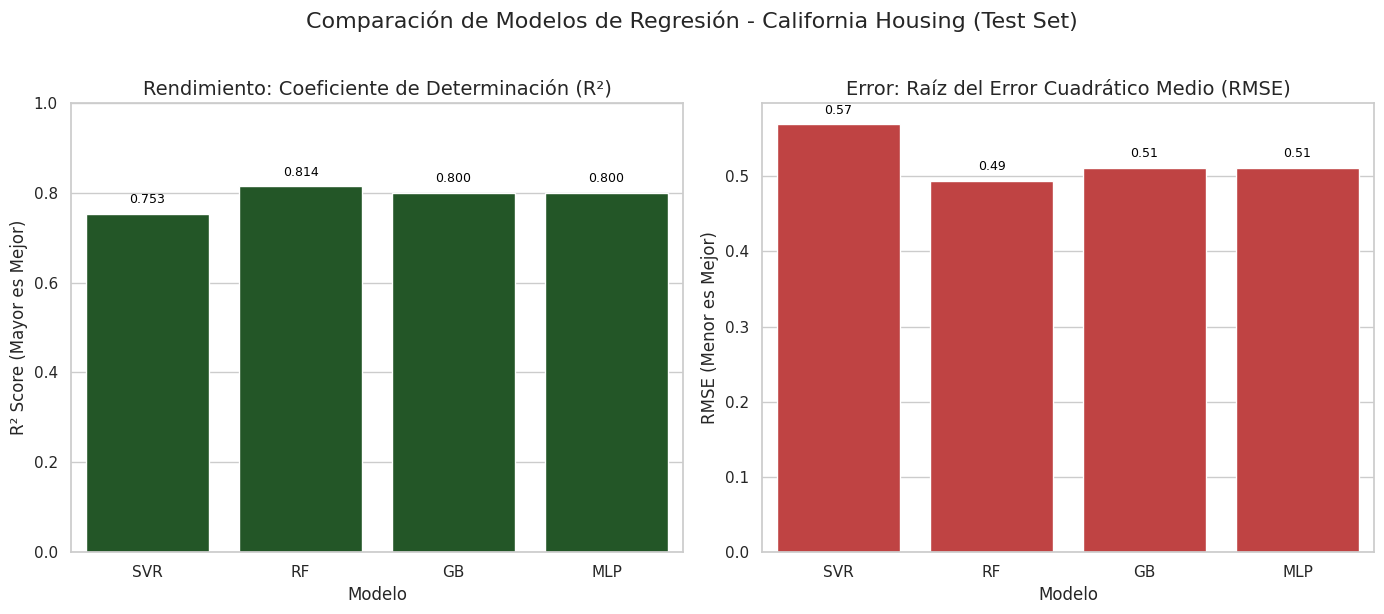

In [14]:
# ===============================================
# BLOQUE 2: Generación de Dos Gráficos Comparativos (COLORES OSCUROS)
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Importar pandas por si se ejecuta por separado

print("\nGenerando dos gráficos comparativos: R² y RMSE (Test Set) con colores oscuros...")

# --- 1. Preparación de datos y Abreviaturas ---
# Asume que df_resultados_reg existe en la memoria
df_grafico = df_resultados_reg[['modelo', 'test_rmse', 'test_r2']].copy()

# Aplicar abreviaturas para etiquetas limpias
abreviaturas = {
    "SVR": "SVR",
    "RandomForestRegressor": "RF",
    "GradientBoostingRegressor": "GB",
    "MLPRegressor": "MLP"
}
df_grafico['modelo'] = df_grafico['modelo'].map(abreviaturas)

# Crear DataFrames separados para cada métrica
df_r2 = df_grafico[['modelo', 'test_r2']].copy()
df_rmse = df_grafico[['modelo', 'test_rmse']].copy()

# --- 2. Configuración de la Figura ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
sns.set_theme(style="whitegrid")

# --- GRÁFICO 1: Coeficiente de Determinación (R²) (Mayor es Mejor) ---

sns.barplot(
    x='modelo',
    y='test_r2',
    data=df_r2,
    ax=axes[0],
    color='#1B5E20' # Verde Oscuro para R²
)

axes[0].set_title('Rendimiento: Coeficiente de Determinación (R²)', fontsize=14)
axes[0].set_ylabel('R² Score (Mayor es Mejor)', fontsize=12)
axes[0].set_xlabel('Modelo', fontsize=12)
axes[0].set_ylim(0.0, 1.0)

# Añadir etiquetas de valor a las barras de R²
for p in axes[0].patches:
    axes[0].annotate(
        f'{p.get_height():.3f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        color='black' # Asegurar que el texto sea legible sobre el color oscuro
    )

# --- GRÁFICO 2: Raíz del Error Cuadrático Medio (RMSE) (Menor es Mejor) ---

sns.barplot(
    x='modelo',
    y='test_rmse',
    data=df_rmse,
    ax=axes[1],
    color='#D32F2F' # Rojo Oscuro para RMSE
)

axes[1].set_title('Error: Raíz del Error Cuadrático Medio (RMSE)', fontsize=14)
axes[1].set_ylabel('RMSE (Menor es Mejor)', fontsize=12)
axes[1].set_xlabel('Modelo', fontsize=12)

# Añadir etiquetas de valor a las barras de RMSE
for p in axes[1].patches:
    axes[1].annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=9,
        color='black'
    )

# Ajustar diseño y mostrar
plt.suptitle('Comparación de Modelos de Regresión - California Housing (Test Set)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Los resultados finales, medidos en el test set, se resumen en el Coeficiente de Determinación (R2) (donde un valor cercano a 1 indica mejor ajuste) y el Error Cuadrático Medio (RMSE) (donde un valor más bajo indica menor error):

   

*   Random Forest Regressor (RF): Demostró ser el modelo más robusto, alcanzando el R2 más alto y el RMSE más bajo.
*   Gradient Boosting Regressor (GB): Tuvo un rendimiento cercano a MLP Regressor (MLP).


*    SVR: Este modelo, que depende del escalado de características,  obtuvo un rendimiento inferior a los otros modelos.


El gráfico comparativo superior presenta la visualización de estos resultados para una comparación directa del rendimiento y el error en el test set.